# Basic Imports

In [1]:
from util import *
import wandb

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2

config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"

!wandb login 4baa24c4fc6c8eed782cacb721d34977149d4fcb

c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Administrator/.netrc


# Create teacher and student model

Both:

In [2]:
teacher, sampler_teacher, student, sampler_student = create_models(config_path, model_path, student=True)

Loading model from d:\OneDrive\Uni\Master_Project_AI\Code\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


Only the student or teacher:

(setting student=False will only return a single model)

In [ ]:
# teacher, sampler_teacher = create_models(config_path, model_path, student=False)
student, sampler_student = create_models(config_path, model_path, student=False)

## Generating WITHOUT intermediates saved

In [ ]:
img, x_T_copy, class_prompt, intermediates  = generate(teacher, sampler_teacher, steps=10, scale=3, keep_intermediates=False)
img

# Generating WITH intermediates saved

In [7]:
intermediates, starting_noise, class_prompt = return_intermediates_for_student(teacher, sampler_teacher, steps=250)

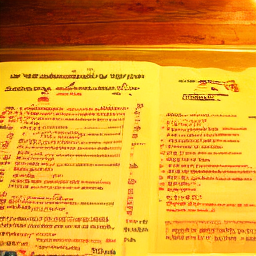

In [14]:
latent_to_img(teacher, intermediates[125])

# Creating a dataset

In [4]:
# dataset_path = f"{cwd}/data/pre_generated/teacher_128/"
# dataset_name = "teacher_128.pt"
# make_dataset(teacher, sampler_teacher, 500, 128, dataset_path, dataset_name)

100%|██████████| 500/500 [1:27:11<00:00, 10.46s/it]


# Training student from teacher directly

In [3]:
wandb_session = wandb_log(name="test_loss", lr=0.0003, model=student, tags=["test"], notes="Just a test")

optimizer, scheduler = get_optimizer(sampler_student, iterations=20*100)
teacher_train_student(teacher, sampler_teacher, student, sampler_student, optimizer, scheduler, steps=20, generations=100, lr=0.0003, early_stop=True, session=wandb_session)

wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pmobiluss. Use `wandb login --relogin` to force relogin


Extra, quick comparison:

In [ ]:
images = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[8, 10, 12])
images

# Train student from pre-generated teacher dataset

In [3]:
data_dir = f"{cwd}/data/pre_generated/teacher_128/"
datasets = os.listdir(data_dir)

In [4]:
notes = """This is a serious attempt to distill the 128 step original teacher into a 64 step student, trained on 32000 instances"""
wandb_session = wandb_log(name="Train_student_on_128_pretrained", lr=0.00000001, model=student, tags=["distillation"], notes=notes)

optimizer, scheduler = get_optimizer(sampler_student, iterations=20*100)

for part in datasets:
    dataset = torch.load(data_dir + part)
    train_student_from_dataset(student, sampler_student, dataset, 64, optimizer, scheduler, lr=0.00000001, early_stop=True, session=wandb_session)

wandb.finish()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pmobiluss. Use `wandb login --relogin` to force relogin


 23%|██▎       | 23/100 [06:29<21:43, 16.92s/it, loss=0.000617]


KeyboardInterrupt: 

In [ ]:
# train_student_from_dataset(student, sampler_student, dataset, 64, lr=0.00000001, early_stop=True)


# Direct Comparison

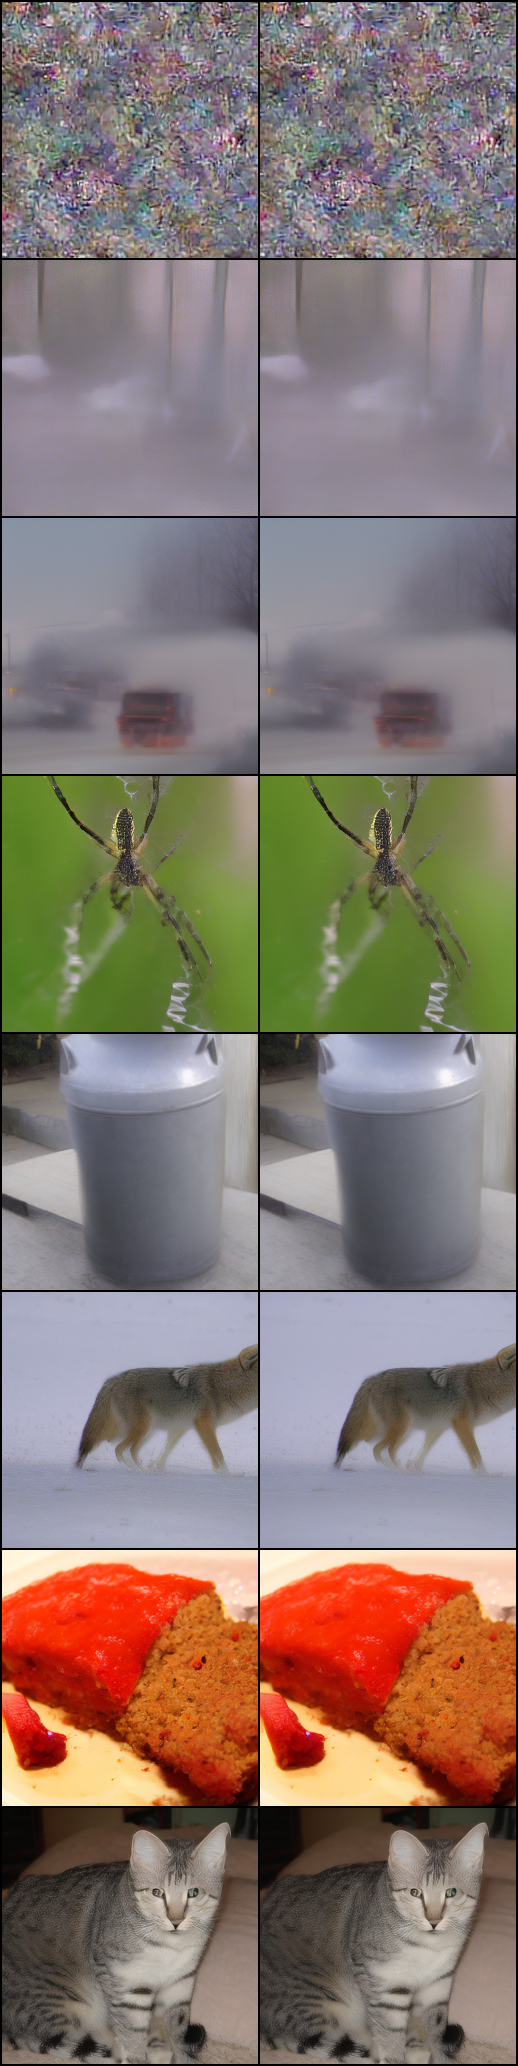

In [10]:
images = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[1, 2, 4, 6, 8, 10, 12, 14])
images